# MNIST Example

This notebook illustrates the use of the proposed in(n)vestigation methods on the MNIST dataset.

# Imports

In [1]:
import warnings
warnings.simplefilter('ignore')

In [12]:
%matplotlib inline  

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import imp
import time
import os

import keras
import keras.backend
import keras.models
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Input
from keras.optimizers import RMSprop, Adam

import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.tests.networks.base
import innvestigate.utils.visualizations as ivis


eutils = imp.load_source("utils", "../utils.py")
mnistutils = imp.load_source("utils_mnist", "../utils_mnist.py")

# Data

Load MNIST data.

In [3]:
# Load data
channels_first = keras.backend.image_data_format == "channels_first"
data = mnistutils.fetch_data(channels_first)
num_classes = len(np.unique(data[1]))

# Test samples for illustrations
images = [(data[2][i].copy(), data[3][i]) for i in range(num_classes)]
label_to_class_name = [str(i) for i in range(num_classes)]

60000 train samples
10000 test samples


Preprocess data.

In [4]:
input_range = [0, 1]
data_preprocessed = (mnistutils.preprocess(data[0],input_range), data[1],
                     mnistutils.preprocess(data[2],input_range), data[3]) 

# Model

Create & train a Multilayer Perceptron with two fully connected layers.

In [5]:
# Parameter
batch_size = 64
epochs = 10
activation_type = "relu"

# Create & train model
model, modelp = mnistutils.create_model(channels_first, activation_type, num_classes)
mnistutils.train_model(modelp, data_preprocessed, batch_size=batch_size, epochs=epochs)
model.set_weights(modelp.get_weights())

Epoch 1/10
60000/60000 [==============================] - 17s 276us/step - loss: 0.2231 - acc: 0.9342
Epoch 2/10
60000/60000 [==============================] - 16s 273us/step - loss: 0.0955 - acc: 0.9705
Epoch 3/10
60000/60000 [==============================] - 16s 269us/step - loss: 0.0667 - acc: 0.9794
Epoch 4/10
60000/60000 [==============================] - 16s 268us/step - loss: 0.0522 - acc: 0.9837
Epoch 5/10
60000/60000 [==============================] - 16s 269us/step - loss: 0.0405 - acc: 0.9876
Epoch 6/10
60000/60000 [==============================] - 16s 271us/step - loss: 0.0335 - acc: 0.9891
Epoch 7/10
60000/60000 [==============================] - 16s 273us/step - loss: 0.0292 - acc: 0.9902
Epoch 8/10
60000/60000 [==============================] - 17s 283us/step - loss: 0.0256 - acc: 0.9914
Epoch 9/10
60000/60000 [==============================] - 20s 339us/step - loss: 0.0232 - acc: 0.9923
Epoch 10/10
60000/60000 [==============================] - 19s 311us/step - loss: 

# Analysis

Use below specified methods to in(n)vestigate and visualize the learned classifier on a few example images. 

Hereby the analyse method containing name, optional parameter, postprocessing information and a title for the final visualisation is passed into the framework by a n-tuple. The available methods are subdivided into three groups depending on their principal approach: gradient-based, pattern-based and relevance-based investigation methods. For a full list of methods please refer to the script in `innvestigate/innvestigate/analyzer/__init__.py`.

In [6]:
# Create list of in(n)vestigation methods we want to apply to the trained model, if applicable specify optional 
# parameters

methods = [
    # NAME                                             POSTPROCESSING       TITLE

    # Show input.
    ("input",                 {},                       mnistutils.image,   "Input"),

    # Function
    ("gradient",              {},                       mnistutils.graymap, "Gradient"),
    ("smoothgrad",            {"noise_scale": 50},      mnistutils.graymap, "SmoothGrad"),
    ("integrated_gradients",  {},                       mnistutils.graymap, ("Integrated", "Gradients")),

    # Signal
    ("deconvnet",             {},                       mnistutils.bk_proj, "Deconvnet"),
    ("guided_backprop",       {},                       mnistutils.bk_proj, ("Guided", "Backprop"),),
    ("pattern.net",           {},                       mnistutils.bk_proj, "PatterNet"),

    # Interaction
    ("pattern.attribution",   {},                       mnistutils.heatmap, "Pattern", "Attribution"),
    ("lrp.z",                 {},                       mnistutils.heatmap, "LRP Z"),
    ("lrp.epsilon",           {},                       mnistutils.heatmap, "LRP Epsilon"),
    ("lrp.alpha_1_beta_0",    {},                       mnistutils.heatmap, "LRP Alpha=1 Beta=0")
]

In [16]:
# Create analyzers.
pattern_type = activation_type
analyzers = []
print('Create analyzer for ', flush=True)
for method in methods:
    print('{} '.format(''.join(method[3])), flush=True)
    analyzer = innvestigate.create_analyzer(method[0],
                                            model,
                                            **method[1])
    analyzer.fit(data_preprocessed[0], pattern_type=pattern_type,
                 batch_size=256, verbose=1)
    analyzers.append(analyzer)

# Apply analyzers to trained model.
analysis = np.zeros([len(images), len(analyzers), 28, 28, 3])
text = []
for i, (image, y) in enumerate(images):
    image = image[None, :, :, :]
    # Predict label.
    x = mnistutils.preprocess(image, input_range)
    presm = model.predict_on_batch(x)[0]
    prob = modelp.predict_on_batch(x)[0]
    y_hat = prob.argmax()
    
    # Save label, pre-softmax activation, probabilistic output and predicted label for plots
    text.append(("%s" %label_to_class_name[y], "%.2f" %presm.max(), 
                 "%.2f" % prob.max(), "%s" %label_to_class_name[y_hat]))
    
    for aidx, analyzer in enumerate(analyzers):
        # Measure execution time
        t_start = time.time()
        print('{} '.format(''.join(methods[aidx][-1])), end='', flush=True)
        
        is_input_analyzer = methods[aidx][0] == "input"
        # Analyze.
        a = analyzer.analyze(image if is_input_analyzer else x)
        
        t_elapsed = time.time() - t_start
        print('({:.4f}s) '.format(t_elapsed), end='', flush=True)
        
        # Postprocess.
        if not is_input_analyzer:
            a = mnistutils.postprocess(a)
        a = methods[aidx][2](a)
        analysis[i, aidx] = a[0]

Create analyzer for 
Input 
Gradient 
SmoothGrad 
IntegratedGradients 
Deconvnet 
GuidedBackprop 
PatterNet 
Epoch 1/1
235/235 [==============================] - 17s 71ms/step - loss: 2.0000 - broadcast_25_loss: 1.0000 - broadcast_26_loss: 1.0000
Pattern 
Epoch 1/1
235/235 [==============================] - 17s 73ms/step - loss: 2.0000 - broadcast_27_loss: 1.0000 - broadcast_28_loss: 1.0000
LRP Z 
LRP Epsilon 
LRP Alpha=1 Beta=0 


Input (0.2365s) Gradient (0.3127s) SmoothGrad (0.6574s) IntegratedGradients (0.8322s) Deconvnet (1.2739s) GuidedBackprop (0.3073s) PatterNet (3.5824s) Attribution (3.3415s) LRP Z (1.8847s) LRP Epsilon (1.9058s) LRP Alpha=1 Beta=0 (3.7470s) 

Input (0.0013s) Gradient (0.0025s) SmoothGrad (0.0125s) IntegratedGradients (0.0115s) Deconvnet (0.0032s) GuidedBackprop (0.0032s) PatterNet (0.0023s) Attribution (0.0031s) LRP Z (0.0021s) LRP Epsilon (0.0028s) LRP Alpha=1 Beta=0 (0.0034s) 

Input (0.0012s) Gradient (0.0029s) SmoothGrad (0.0118s) IntegratedGradients (0.0

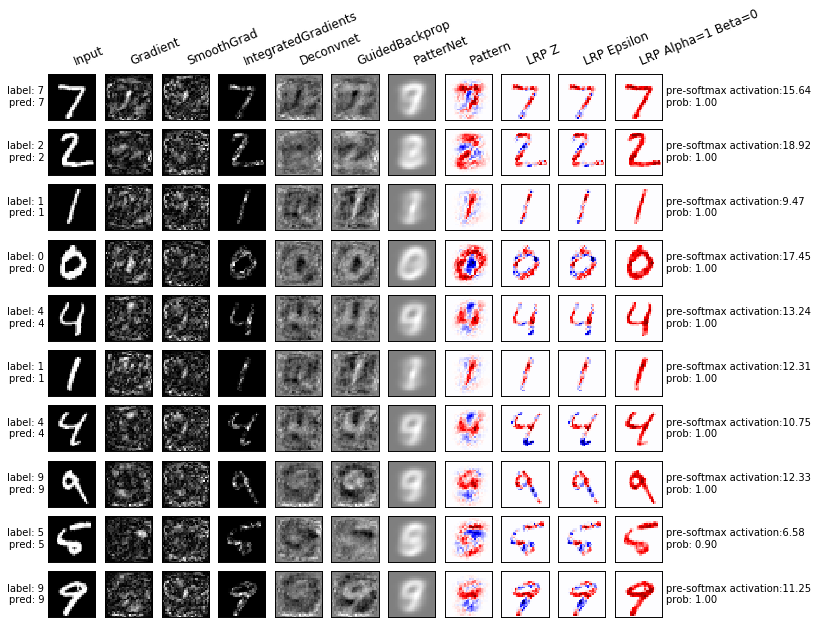

In [8]:
# Plot the analysis.

grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]
row_labels = text
col_labels = [''.join(method[3]) for method in methods]

eutils.plot_image_grid(grid, row_labels, col_labels,
                       file_name=None,
                       row_label_offset=0,
                       col_label_offset=0,
                       is_fontsize_adaptive=True,
                       usetex=False,
                       dpi=224)